# A2C - Advantage Actor Critic

Como vimos na aula de Policy Gradients, existem algoritmos capazes de aprender a política diretamente, utilizando gradiente ascendente neste processo. Porém, modelos como REINFORCE sofrem com grande variância. Para tentar solucionar este problema, surge a ideia de utilizar uma estimativa do retorno. Cada uma dessas estimativas leva a diferentes algoritmos Actor-Critic. Hoje, vamos abordar uma delas, a Advantage (vantagem):

\begin{align*}
  \nabla_\theta J(\theta) &=  \mathbb{E}_{\pi_\theta} [\nabla_\theta log \pi_\theta(s,a)\ G_t]\ \ \ \text{REINFORCE} \\

  \nabla_\theta J(\theta) &=  \mathbb{E}_{\pi_\theta} [\nabla_\theta log \pi_\theta(s,a)\ Q^w(s,a)]\ \ \ \text{Q Actor-Critic} \\

  \nabla_\theta J(\theta) &=  \mathbb{E}_{\pi_\theta} [\nabla_\theta log \pi_\theta(s,a)\ A^w(s,a)]\ \ \ \text{Advantage Actor-Critic} \\

  \nabla_\theta J(\theta) &=  \mathbb{E}_{\pi_\theta} [\nabla_\theta log \pi_\theta(s,a)\ \delta]\ \ \ \text{TD Actor-Critic}
\end{align*}



## O Ator e o Crítico

Antes de entrarmos no A2C em si, é interessante explorar o que cada parte do algoritmo faz. Resumindo, o **crítico** atualiza as estimativas da função valor enquanto o **ator** busca atualizar a política na direção sugerida pelo crítico.

![interacao actor-critic](https://miro.medium.com/max/390/1*-GfRVLWhcuSYhG25rN0IbA.png)

Para entender um pouco melhor, de uma forma mais alto nível, [recomendo essa história em quadrinhos](https://hackernoon.com/intuitive-rl-intro-to-advantage-actor-critic-a2c-4ff545978752) (sim, existem historias em quadrinhos de RL)

Enxergando de outra forma, temos que o crítico é a função valor, medindo o quão boas são as ações tomadas, enquanto o ator é a função política, controlando as ações.

* Ator: $\pi(s, a, \theta)$
* Crítico: $\hat{q}(s, a, \omega)$


## Advantage

Uma das baselines que pode ser desenvolvida é a chamada vantagem, que é definida da seguinte forma:

$$A(s, a) = Q(s, a) - V(s)$$

Em resumo, a vantagem busca medir de forma *relativa* o valor de uma ação comparando com o valor médio das ações naquele estado. Se o valor da vantagem é positivo, levamos o nosso gradiente nesta direção.

Uma das formas de estimar o valor de A(s, a) é usando o nosso velho amigo **bootstrapping**, onde podemos estimar o Q da seguinte forma:

$$Q(s,a) = r + \gamma V(s')$$

Reescrevendo a vantagem, temos que ela pode ser aproximada a seguir:

$$A(s,a) = r + \gamma V(s') - V(s)$$

É interessante notar que essa forma de aproximar a vantagem usa o mesmo cálculo do Erro de Temporal Difference: $\delta_t = r + \gamma V(s') - V(s)$. Apesar disso, a vantagem também pode ser aproximada de outras maneiras.

Com essa fórmula, precisamos estimar somente V e não Q. Existem outras formas de estimar a vantagem, como a [Generalized Advantage Estimation](https://arxiv.org/pdf/1506.02438.pdf)

Dessa forma, podemos estimar o gradiente do Advantage Actor-Critic pela seguinte equação:

$$\nabla_\theta J(\theta) \approx \sum_{t = 0}^{T-1}  \nabla_\theta log \pi_\theta(s,a)(r_{t+1} + \gamma V(s_{t+1}) - V(s_t))$$

### A3C vs A2C

O algoritmo inicial foi o A3C (Asynchronous Advantage Actor Critic), por meio de um paper da Deepmind ([Paper de A3C](https://arxiv.org/abs/1602.01783)). Segundo a OpenAI, a parte assíncrona do A3C não traz grande vantagem e é menos eficiente, por isso a ideia do A2C. Não tenho capacidade de entrar no mérito, então vou só pontuar as diferenças.


Ambos os algoritmos atuam em múltiplos ambientes simultâneos, mas enquanto o A3C é atualizado cada vez que um deles termina uma batch de experiências, por isso assíncrono, o A2C espera todos os agentes obterem uma batch para então atualizar com todas simultaneamente, usando a média do update. As diferenças podem ser conferidas [neste link da OpenAI](https://openai.com/blog/baselines-acktr-a2c/).

## Algoritmo do A2C

O pseudocódigo do A2C pode ser visto na imagem a seguir:

<img src="imgs/A2C.svg" width="800" title="pseudocode" />


É importante ressaltar que essa versão utiliza duas redes neurais, uma para o crítico e outra para o ator, mas implementações com uma só rede são possíveis e serão mostradas abaixo.

## Referências
https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f

https://towardsdatascience.com/introduction-to-actor-critic-7642bdb2b3d2

https://www.freecodecamp.org/news/an-intro-to-advantage-actor-critic-methods-lets-play-sonic-the-hedgehog-86d6240171d/

[http://incompleteideas.net/book/first/ebook](http://incompleteideas.net/book/first/ebook/node66.html#:~:text=Actor%2Dcritic%20methods%20are%20TD,independent%20of%20the%20value%20function.&text=This%20scalar%20signal%20is%20the,%3A%20The%20actor%2Dcritic%20architecture)

https://openai.com/blog/baselines-acktr-a2c/

https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#id14


# Código


## Ator

In [1]:
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

class Actor(nn.Module):
    """Rede do Ator."""
    def __init__(self, observation_shape, action_shape):
        """Inicializa a rede.
        
        Parâmetros
        ----------
        observation_shape: int
        Formato do estado do ambiente.
        
        action_shape: int
        Número de ações do ambiente.
        """
        super(Actor, self).__init__()

        self.linear1 = nn.Linear(observation_shape, 128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, action_shape)

    def forward(self, state):
        """
        Calcula a probabilidade de ação para o estado atual.
        
        Parâmetros
        ----------
        state: np.array
        Estado atual.
        
        Retorna
        -------
        probs: Categorical
        Distribuição de probabilidade das ações.
        """
        dists = F.relu(self.linear1(state))
        dists = F.relu(self.linear2(dists))
        dists = F.softmax(self.linear3(dists), dim=1)
        probs = Categorical(dists)

        return probs

## Crítico

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Critic(nn.Module):
    """Rede do Crítico."""
    def __init__(self, observation_shape):
        """Inicializa a rede.
        
        Parâmetros
        ----------
        observation_shape: int
        Formato do estado do ambiente.
        """
        super(Critic, self).__init__()

        self.linear1 = nn.Linear(observation_shape, 64)
        self.linear2 = nn.Linear(64, 64)
        self.linear3 = nn.Linear(64, 1)

    def forward(self, state):
        """
        Calcula o valor do estado atual.
        
        Parâmetros
        ----------
        state: np.array
        Estado atual.
        
        Retorna
        -------
        v: float
        Valor do estado atual.
        """
        v = F.relu(self.linear1(state))
        v = F.relu(self.linear2(v))
        v = self.linear3(v)

        return v

## Memory Buffer

In [3]:
import numpy as np

class MemoryBuffer:
    """Memory Buffer Buffer para A2C."""
    def __init__(self, max_length, observation_space):
        """Cria um Replay Buffer.

        Parâmetros
        ----------
        max_length: int
            Tamanho máximo do Replay Buffer.
        observation_space: int
            Tamanho do espaço de observação.
        """
        self.length = 0
        self.max_length = max_length

        self.states = np.zeros((max_length, observation_space), dtype=np.float32)
        self.actions = np.zeros((max_length), dtype=np.int32)
        self.rewards = np.zeros((max_length), dtype=np.float32)
        self.next_states = np.zeros((max_length, observation_space), dtype=np.float32)
        self.dones = np.zeros((max_length), dtype=np.float32)

    def update(self, states, actions, rewards, next_states, dones):
        """Adiciona uma experiência ao Replay Buffer.

        Parâmetros
        ----------
        state: np.array
            Estado da transição.
        action: int
            Ação tomada.
        reward: float
            Recompensa recebida.
        state: np.array
            Estado seguinte.
        done: int
            Flag indicando se o episódio acabou.
        """
        self.states[self.length] = states
        self.actions[self.length] = actions
        self.rewards[self.length] = rewards
        self.next_states[self.length] = next_states
        self.dones[self.length] = dones
        self.length += 1

    def get_batch(self):
        """Retorna um batch de experiências.
        
        Parâmetros
        ----------
        batch_size: int
            Tamanho do batch de experiências.

        Retorna
        -------
        states: np.array
            Batch de estados.
        actions: np.array
            Batch de ações.
        rewards: np.array
            Batch de recompensas.
        next_states: np.array
            Batch de estados seguintes.
        dones: np.array
            Batch de flags indicando se o episódio acabou.
        """
        self.length = 0

        return (self.states, self.actions, self.rewards, self.next_states, self.dones)

## Agente

In [4]:
import torch
import torch.optim as optim

class A2C:
    def __init__(self, observation_space, action_space, p_lr=5e-4, v_lr=7e-4, gamma=0.99, entropy_coef=0.005, n_steps=5):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.gamma = gamma
        self.entropy_coef = entropy_coef

        self.n_steps = n_steps
        self.memory = MemoryBuffer(n_steps, observation_space.shape[0])

        self.actor = Actor(observation_space.shape[0], action_space.n).to(self.device)
        self.critic = Critic(observation_space.shape[0]).to(self.device)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=p_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=v_lr)

    def act(self, state):
        state = torch.FloatTensor(state).to(self.device).unsqueeze(0)
        probs = self.actor.forward(state)
        
        action = probs.sample().cpu().detach().item()
        return action

    def remember(self, state, action, reward, next_state, done):
        self.memory.update(state, action, reward, next_state, done)

    def compute_advantages(self, rewards, dones, v, v2):
        T = len(rewards)

        returns = torch.zeros_like(rewards).to(self.device)
        advantages = torch.zeros_like(rewards).to(self.device)
        
        next_return = torch.tensor(v2[-1], dtype=rewards.dtype).to(self.device)

        not_dones = 1 - dones
        advantages = rewards + not_dones * self.gamma * v2 - v

        for t in reversed(range(T)):
            returns[t] = next_return = rewards[t] + self.gamma * not_dones[t] * next_return

        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8) # Normalização

        return advantages, returns

    def train(self):
        if self.memory.length < self.n_steps:
            return

        (states, actions, rewards, next_states, dones) = self.memory.get_batch()

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.FloatTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(-1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(-1).to(self.device)

        v = self.critic.forward(states)
        with torch.no_grad():
          v2 = self.critic.forward(next_states)

        advantages, returns = self.compute_advantages(rewards, dones, v, v2)

        probs = self.actor.forward(states)
        logp = -probs.log_prob(actions)
        entropy = probs.entropy().mean()

        policy_loss =   (logp.unsqueeze(-1) * advantages.detach()).mean()
        value_loss =    F.mse_loss(v, returns.detach())
        entropy_loss = -self.entropy_coef * entropy

        self.actor_optimizer.zero_grad()
        (policy_loss + entropy_loss).backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        value_loss.backward()
        self.critic_optimizer.step()

        return float(policy_loss + entropy_loss + value_loss)

## Treinando

In [5]:
import math
from collections import deque

def train(agent, env, total_timesteps):
    total_reward = 0
    episode_returns = deque(maxlen=20)
    avg_returns = []

    state = env.reset()
    timestep = 0
    episode = 0

    while timestep < total_timesteps:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        loss = agent.train()
        timestep += 1

        total_reward += reward

        if done:
            episode_returns.append(total_reward)
            episode += 1
            next_state = env.reset()

        if episode_returns:
            avg_returns.append(np.mean(episode_returns))

        total_reward *= 1 - done
        state = next_state

        ratio = math.ceil(100 * timestep / total_timesteps)

        avg_return = avg_returns[-1] if avg_returns else np.nan
        
        print(f"\r[{ratio:3d}%] timestep = {timestep}/{total_timesteps}, episode = {episode:3d}, avg_return = {avg_return:10.4f}", end="")

    return avg_returns

In [6]:
import gym

env = gym.make("CartPole-v1")

In [7]:
agent = A2C(env.observation_space, env.action_space)

In [8]:
returns = train(agent, env, 75000)

[  1%] timestep = 40/75000, episode =   2, avg_return =    20.0000

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[100%] timestep = 75000/75000, episode = 960, avg_return =   340.3500

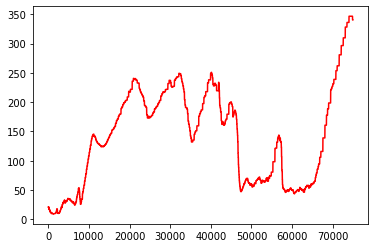

In [10]:
import matplotlib.pyplot as plt

plt.plot(returns, 'r')
plt.show()

Como foi possível observar, não obtivemos uma performance muito boa com o nosso algoritmo. Dessa forma, para melhorar o nosso resultado, podemos juntar as duas redes de Ator e de Crítico em uma só, usando somente uma função de custo, acelerando o treinamento e o tornando mais robusto.

##  Rede Dividida

In [11]:
class ActorCritic(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super(ActorCritic, self).__init__()
        self.policy1 = nn.Linear(observation_shape, 64)
        self.policy2 = nn.Linear(64, 64)
        self.policy3 = nn.Linear(64, action_shape)
        
        self.value1 = nn.Linear(observation_shape, 64)
        self.value2 = nn.Linear(64, 64)
        self.value3 = nn.Linear(64, 1)

    def forward(self, state):
        dists = torch.tanh(self.policy1(state))
        dists = torch.tanh(self.policy2(dists))
        dists = F.softmax(self.policy3(dists), dim=-1)
        probs = Categorical(dists)
        
        v = torch.tanh(self.value1(state))
        v = torch.tanh(self.value2(v))
        v = self.value3(v)

        return probs, v

In [16]:
class SharedA2C:
    def __init__(self, observation_space, action_space, lr=7e-4, gamma=0.99, lam=0.95, vf_coef=0.5, entropy_coef=0.005, n_steps=5):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.gamma = gamma
        self.lam = lam
        self.vf_coef = vf_coef
        self.entropy_coef = entropy_coef

        self.n_steps = n_steps
        self.memory = MemoryBuffer(n_steps, observation_space.shape[0])

        self.actorcritic = ActorCritic(observation_space.shape[0], action_space.n).to(self.device)
        self.actorcritic_optimizer = optim.Adam(self.actorcritic.parameters(), lr=lr)

    def act(self, state):
        state = torch.FloatTensor(state).to(self.device).unsqueeze(0)
        probs, _ = self.actorcritic.forward(state)
        action = probs.sample().cpu().detach().item()
        return action

    def remember(self, state, action, reward, next_state, done):
        self.memory.update(state, action, reward, next_state, done)

    def compute_gae(self, rewards, dones, v, v2):
        T = len(rewards)

        returns = torch.zeros_like(rewards).to(self.device)
        gaes = torch.zeros_like(rewards).to(self.device)
        
        future_gae = torch.tensor(0.0, dtype=rewards.dtype).to(self.device)
        next_return = torch.tensor(v2[-1], dtype=rewards.dtype).to(self.device)

        not_dones = 1 - dones
        deltas = rewards + not_dones * self.gamma * v2 - v

        for t in reversed(range(T)):
            returns[t] = next_return = rewards[t] + self.gamma * not_dones[t] * next_return
            gaes[t] = future_gae = deltas[t] + self.gamma * self.lam * not_dones[t] * future_gae

        gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8) # Normalização

        return gaes, returns

    def train(self):
        if self.memory.length < self.n_steps:
            return

        (states, actions, rewards, next_states, dones) = self.memory.get_batch()

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.FloatTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(-1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(-1).to(self.device)

        probs, v = self.actorcritic.forward(states)
        with torch.no_grad():
          _, v2 = self.actorcritic.forward(next_states)

        advantages, returns = self.compute_gae(rewards, dones, v, v2)

        logp = -probs.log_prob(actions)
        entropy = probs.entropy().mean()

        policy_loss =   (logp.unsqueeze(-1) * advantages.detach()).mean()
        value_loss =    self.vf_coef * F.mse_loss(v, returns.detach())
        entropy_loss = -self.entropy_coef * entropy

        self.actorcritic_optimizer.zero_grad()
        (policy_loss + entropy_loss + value_loss).backward()
        self.actorcritic_optimizer.step()

        return policy_loss + entropy_loss + value_loss

In [17]:
env = gym.make("CartPole-v1")

In [18]:
agent = SharedA2C(env.observation_space, env.action_space)

In [19]:
returns = train(agent, env, 75000)

[  1%] timestep = 35/75000, episode =   1, avg_return =    18.0000

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[100%] timestep = 75000/75000, episode = 661, avg_return =   500.0000

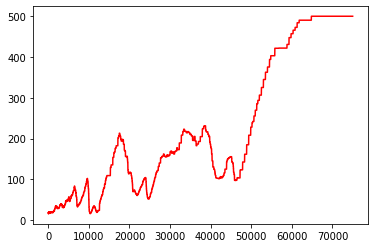

In [20]:
import matplotlib.pyplot as plt

plt.plot(returns, 'r')
plt.show()

## Múltiplos Ambientes

In [21]:
import numpy as np

class MultipleMemoryBuffer:
    def __init__(self, max_length, env_num, observation_space):
        self.length = 0
        self.max_length = max_length

        self.states = np.zeros((max_length, env_num, observation_space), dtype=np.float32)
        self.actions = np.zeros((max_length, env_num), dtype=np.int32)
        self.rewards = np.zeros((max_length, env_num), dtype=np.float32)
        self.next_states = np.zeros((max_length, env_num, observation_space), dtype=np.float32)
        self.dones = np.zeros((max_length, env_num), dtype=np.float32)

    def update(self, states, actions, rewards, next_states, dones):
        self.states[self.length] = states
        self.actions[self.length] = actions
        self.rewards[self.length] = rewards
        self.next_states[self.length] = next_states
        self.dones[self.length] = dones
        self.length += 1

    def get_batch(self):
        self.length = 0

        return (self.states, self.actions, self.rewards, self.next_states, self.dones)

In [22]:
class ActorCritic(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super(ActorCritic, self).__init__()
        self.policy1 = nn.Linear(observation_shape, 64)
        self.policy2 = nn.Linear(64, 64)
        self.policy3 = nn.Linear(64, action_shape)
        
        self.value1 = nn.Linear(observation_shape, 64)
        self.value2 = nn.Linear(64, 64)
        self.value3 = nn.Linear(64, 1)

    def forward(self, state):
        dists = torch.tanh(self.policy1(state))
        dists = torch.tanh(self.policy2(dists))
        dists = F.softmax(self.policy3(dists), dim=-1)
        probs = Categorical(dists)
        
        v = torch.tanh(self.value1(state))
        v = torch.tanh(self.value2(v))
        v = self.value3(v)

        return probs, v

In [23]:
class SharedA2C:
    def __init__(self, observation_space, action_space, env_num, lr=7e-4, gamma=0.99, lam=0.95, vf_coef=0.5, entropy_coef=0.005, n_steps=5):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.gamma = gamma
        self.lam = lam
        self.vf_coef = vf_coef
        self.entropy_coef = entropy_coef

        self.n_steps = n_steps
        self.memory = MultipleMemoryBuffer(n_steps, env_num, observation_space.shape[0])

        self.actorcritic = ActorCritic(observation_space.shape[0], action_space.n).to(self.device)
        self.actorcritic_optimizer = optim.Adam(self.actorcritic.parameters(), lr=lr)

    def act(self, state):
        state = torch.FloatTensor(state).to(self.device)
        probs, _ = self.actorcritic.forward(state)
        action = probs.sample().cpu().detach().numpy()
        return action

    def remember(self, state, action, reward, next_state, done):
        self.memory.update(state, action, reward, next_state, done)

    def compute_gae(self, rewards, dones, v, v2):
        T = len(rewards)

        returns = torch.zeros_like(rewards).to(self.device)
        gaes = torch.zeros_like(rewards).to(self.device)
        
        future_gae = torch.tensor(0.0, dtype=rewards.dtype).to(self.device)
        next_return = torch.tensor(v2[-1], dtype=rewards.dtype).to(self.device)

        not_dones = 1 - dones
        deltas = rewards + not_dones * self.gamma * v2 - v

        for t in reversed(range(T)):
            returns[t] = next_return = rewards[t] + self.gamma * not_dones[t] * next_return
            gaes[t] = future_gae = deltas[t] + self.gamma * self.lam * not_dones[t] * future_gae

        gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8) # Normalização

        return gaes, returns

    def train(self):
        if self.memory.length < self.n_steps:
            return

        (states, actions, rewards, next_states, dones) = self.memory.get_batch()

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.FloatTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(-1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(-1).to(self.device)

        probs, v = self.actorcritic.forward(states)
        with torch.no_grad():
          _, v2 = self.actorcritic.forward(next_states)

        advantages, returns = self.compute_gae(rewards, dones, v, v2)

        logp = -probs.log_prob(actions)
        entropy = probs.entropy().mean()

        policy_loss =   (logp.unsqueeze(-1) * advantages.detach()).mean()
        value_loss =    self.vf_coef * F.mse_loss(v, returns.detach())
        entropy_loss = -self.entropy_coef * entropy

        self.actorcritic_optimizer.zero_grad()
        (policy_loss + entropy_loss + value_loss).backward()
        self.actorcritic_optimizer.step()

        return policy_loss + entropy_loss + value_loss

In [24]:
env = gym.vector.make("CartPole-v1", num_envs=8, asynchronous=True)

In [25]:
agent = SharedA2C(env.single_observation_space, env.single_action_space, env.num_envs)

In [26]:
import time

def vector_train(agent, env, total_timesteps):
    total_rewards = [[] for _ in range(env.num_envs)]
    avg_total_rewards = []

    total_reward = np.zeros(env.num_envs)
    observations = env.reset()
    timestep = 0
    episode = 0

    t = 0

    start_time = time.time()

    while timestep < total_timesteps:
        actions = agent.act(observations)
        next_observations, rewards, dones, _ = env.step(actions)
        agent.remember(observations, actions, rewards, next_observations, dones)
        agent.train()
        
        timestep += len(observations)
        t += 1

        total_reward += rewards

        for i in range(env.num_envs):
            if dones[i]:
                total_rewards[i].append((t, timestep, total_reward[i]))
                episode += 1

        if any(G for G in total_rewards):
            episode_returns = sorted(
                list(np.concatenate([G for G in total_rewards if G])),
                key=lambda x: x[1]
            )

            avg_total_rewards.append(np.mean([G[-1] for G in episode_returns[-20:]]))

        total_reward *= 1 - dones
        observations = next_observations

        ratio = math.ceil(100 * timestep / total_timesteps)
        uptime = math.ceil(time.time() - start_time)

        avg_return = avg_total_rewards[-1] if avg_total_rewards else np.nan

        print(f"\r[{ratio:3d}% / {uptime:3d}s] timestep = {timestep}/{total_timesteps}, episode = {episode:3d}, avg_return = {avg_return:10.4f}", end="")

    print("\n")
    return avg_total_rewards

In [27]:
returns = vector_train(agent, env, 125000)

[  1% /   1s] timestep = 32/125000, episode =   0, avg_return =        nan

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[100% / 163s] timestep = 125000/125000, episode = 1219, avg_return =   360.8500



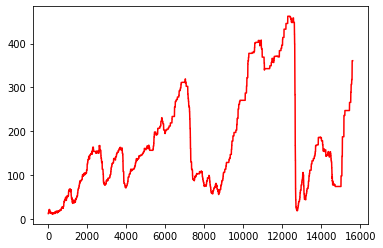

In [28]:
import matplotlib.pyplot as plt

plt.plot(returns, 'r')
plt.show()